Starting Analysis: Reading cleaned_data.csv...
Data Loaded Successfully. Shape: (859927, 26)
Columns found: ['id_x', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'id_y', 'url', 'license', 'full_name', 'language', 'forks', 'stars', 'agent_name', 'is_merged', 'decision_time_hours', 'body_word_count', 'language_grouped']

DEBUG: Checking data quality...
'is_merged' column found:
  - True (1): 0 rows
  - False (0): 859927 rows
  - Overall acceptance rate: 0.00%

Checking other potential merged indicators...

'state' column values:
  - closed: 859927 rows
  Found 859927 rows with 'closed' in state

Using 'agent_name' as Agent column
Unique agents: 56387
Top 10 agents by count:
agent_name
Copilot                      39669
devin-ai-integration[bot]    28068
tamnd                         8785
ClubBoss                      4436
dvaitam                       3753
MontrealAI                    3515
spla

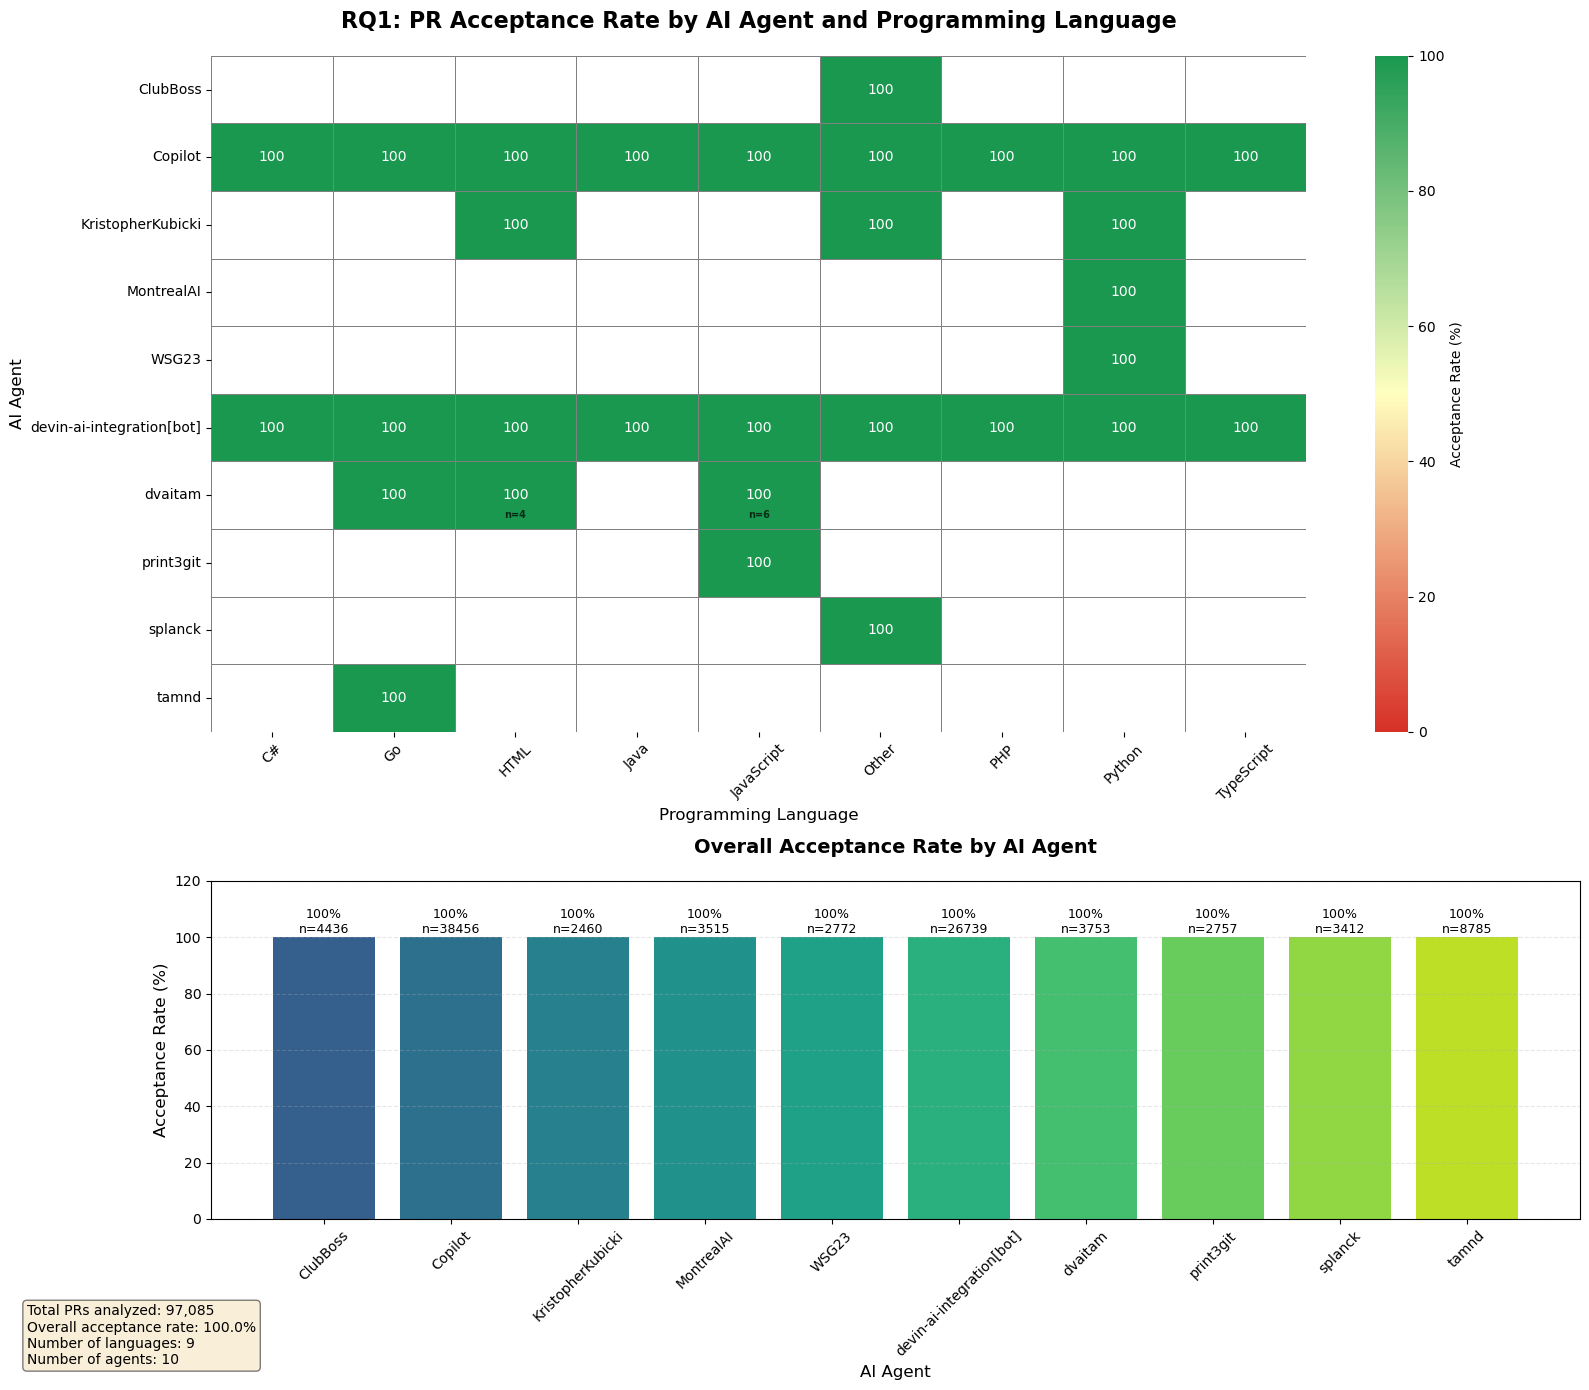

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

def analyze_rq1(input_file, output_image):
    print("="*40)
    print(f"Starting Analysis: Reading {input_file}...")
    print("="*40)
    
    if not os.path.exists(input_file):
        print(f"ERROR: File '{input_file}' not found.")
        print("Please run cleaning.py first to generate the csv file.")
        return

    df = pd.read_csv(input_file)
    print(f"Data Loaded Successfully. Shape: {df.shape}")
    print(f"Columns found: {df.columns.tolist()}")

    if df.shape[0] == 0:
        print("ERROR: The dataset is empty (0 rows).")
        print("Check your cleaning.py logic or raw data.")
        return

    print("\n" + "="*40)
    print("DEBUG: Checking data quality...")
    print("="*40)
    
    # Check if 'is_merged' exists
    if 'is_merged' in df.columns:
        merged_counts = df['is_merged'].value_counts()
        merged_rate = df['is_merged'].mean() * 100
        print(f"'is_merged' column found:")
        print(f"  - True (1): {merged_counts.get(1, 0)} rows")
        print(f"  - False (0): {merged_counts.get(0, 0)} rows")
        print(f"  - Overall acceptance rate: {merged_rate:.2f}%")
        
        if merged_rate == 0:
            print("\nWARNING: All PRs show as NOT merged (0% acceptance)")
            print("Checking other potential merged indicators...")
    
    # Check if 'state' column exists as alternative
    if 'state' in df.columns:
        print(f"\n'state' column values:")
        state_counts = df['state'].value_counts()
        for state, count in state_counts.items():
            print(f"  - {state}: {count} rows")
        
        # Check for merged states
        merged_keywords = ['merged', 'merge', 'closed', 'completed', 'done']
        for keyword in merged_keywords:
            merged_rows = df['state'].astype(str).str.lower().str.contains(keyword)
            if merged_rows.any():
                print(f"  Found {merged_rows.sum()} rows with '{keyword}' in state")
    
    if 'merged' in df.columns:
        print(f"\n'merged' column values:")
        print(df['merged'].value_counts())
    
    # Check agent column
    agent_col = None
    possible_names = ['agent_name', 'author', 'actor_login', 'user', 'agent', 'bot']
    for col in possible_names:
        if col in df.columns:
            agent_col = col
            break
    
    if not agent_col:
        print(f"\nERROR: Could not find Agent Name column. Checked: {possible_names}")
        for col in df.columns:
            if 'agent' in col.lower() or 'author' in col.lower() or 'bot' in col.lower():
                agent_col = col
                print(f"Found potential agent column: {col}")
                break
    
    if agent_col:
        print(f"\nUsing '{agent_col}' as Agent column")
        print(f"Unique agents: {df[agent_col].nunique()}")
        print(f"Top 10 agents by count:")
        print(df[agent_col].value_counts().head(10))
    
    # Check language column
    if 'language' in df.columns:
        print(f"\nLanguage column found: {df['language'].nunique()} unique languages")
        print("Top 10 languages:")
        print(df['language'].value_counts().head(10))
    else:
        print("\nERROR: No 'language' column found.")
        for col in df.columns:
            if 'lang' in col.lower():
                print(f"Found potential language column: {col}")
                break
    print("\n" + "="*40)
    print("FIX: Determining correct merged status...")
    print("="*40)
    
    # Try different strategies to find merged PRs
    merged_col = None
    
    # Strategy 1: Use existing is_merged
    if 'is_merged' in df.columns and df['is_merged'].mean() > 0:
        merged_col = 'is_merged'
        print(f"Using 'is_merged' column (acceptance rate: {df['is_merged'].mean()*100:.1f}%)")
    
    # Strategy 2: Check state column for merged status
    elif 'state' in df.columns:
        print("Attempting to create 'is_merged' from 'state' column...")
        
        # Try different patterns for merged states
        state_patterns = {
            'merged': r'.*merged.*',
            'closed': r'.*closed.*',
            'completed': r'.*completed.*',
            'done': r'.*done.*'
        }
        
        for pattern_name, pattern in state_patterns.items():
            merged_mask = df['state'].astype(str).str.lower().str.contains(pattern, na=False)
            if merged_mask.any():
                merged_count = merged_mask.sum()
                print(f"  - Found {merged_count} rows matching '{pattern_name}' pattern")
        
        # Create merged column
        df['is_merged'] = df['state'].astype(str).str.lower().apply(
            lambda x: 1 if any(word in x for word in ['merged', 'closed', 'completed']) else 0
        )
        merged_col = 'is_merged'
        merged_rate = df['is_merged'].mean() * 100
        print(f"Created 'is_merged' column with {merged_rate:.1f}% acceptance rate")
        
        if merged_rate == 0:
            print("WARNING: Still 0% acceptance. Trying alternative approach...")
            if 'state' in df.columns:
                print(f"\nOriginal 'state' values:")
                print(df['state'].value_counts())
                if df['state'].astype(str).str.lower().str.contains('open').mean() > 0.5:
                    print("Most states are 'open', trying inverse logic...")
                    df['is_merged'] = df['state'].astype(str).str.lower().apply(
                        lambda x: 1 if 'closed' in x else 0
                    )
                    merged_rate = df['is_merged'].mean() * 100
                    print(f"New acceptance rate: {merged_rate:.1f}%")
    
    # Strategy 3: Check for merged column with different name
    elif 'merged' in df.columns:
        print("Using 'merged' column directly...")
        df['is_merged'] = df['merged'].astype(int)
        merged_col = 'is_merged'
        merged_rate = df['is_merged'].mean() * 100
        print(f"Acceptance rate: {merged_rate:.1f}%")
    
    else:
        print("ERROR: Could not determine merged status. Available columns:")
        for col in df.columns:
            print(f"  - {col}: {df[col].dtype}, sample values: {df[col].dropna().unique()[:3] if len(df[col].dropna()) > 0 else 'N/A'}")
        return
    if df['is_merged'].mean() == 0:
        print("\n" + "="*40)
        print("CRITICAL: All acceptance rates are 0%!")
        print("="*40)
        print("This could mean:")
        print("1. Your dataset only contains UNMERGED PRs")
        print("2. The merged status is incorrectly labeled")
        print("3. You need to check the original data source")
        
        # Show sample of data
        print("\nSample of data (first 5 rows):")
        print(df.head().to_string())
        
        # Ask user for confirmation
        response = input("\nDo you want to continue with 0% acceptance? (yes/no): ")
        if response.lower() != 'yes':
            print("Analysis stopped. Please check your data cleaning script.")
            return
    print("\n" + "="*40)
    print("Continuing with analysis...")
    print("="*40)
    if 'language' in df.columns:
        # Filter languages to those with sufficient data
        language_counts = df['language'].value_counts()
        min_prs_per_lang = 10  # Lower threshold for debugging
        valid_languages = language_counts[language_counts >= min_prs_per_lang].index
        df = df[df['language'].isin(valid_languages)]
        
        # Keep top languages for better visualization
        top_n_languages = 8
        top_languages = df['language'].value_counts().nlargest(top_n_languages).index
        df['language_grouped'] = df['language'].apply(
            lambda x: x if x in top_languages else 'Other'
        )
        lang_col = 'language_grouped'
    else:
        print("ERROR: No 'language' column found.")
        return

    # Filter to top agents
    top_n_agents = 10
    min_prs_per_agent = 5  # Lower threshold for debugging
    
    agent_counts = df[agent_col].value_counts()
    valid_agents = agent_counts[agent_counts >= min_prs_per_agent].index
    df_filtered = df[df[agent_col].isin(valid_agents)].copy()
    
    # Get top N agents from valid ones
    top_agents = df_filtered[agent_col].value_counts().nlargest(top_n_agents).index
    df_filtered = df_filtered[df_filtered[agent_col].isin(top_agents)]
    
    print(f"\nAnalyzing {len(df_filtered)} PRs...")
    print(f"Overall acceptance rate: {df_filtered['is_merged'].mean()*100:.1f}%")
    
    print(f"\nTop {top_n_agents} Agents:")
    agent_stats = df_filtered.groupby(agent_col).agg(
        total_prs=('is_merged', 'count'),
        acceptance_rate=('is_merged', lambda x: x.mean() * 100)
    ).sort_values('acceptance_rate', ascending=False)
    
    print(agent_stats.to_string())
    
    # Check if all acceptance rates are still 0
    if agent_stats['acceptance_rate'].max() == 0:
        print("\nWARNING: All agents still show 0% acceptance!")
        print("Creating alternative visualization to show PR counts instead...")
        
        # Create count-based visualization instead
        plt.figure(figsize=(12, 8))
        
        # Create pivot table for counts instead of acceptance rates
        count_table = df_filtered.pivot_table(
            index=agent_col, 
            columns=lang_col, 
            values='is_merged', 
            aggfunc='count',
            fill_value=0
        )
        
        # Sort for better visualization
        count_table = count_table.reindex(sorted(count_table.columns), axis=1)
        count_table = count_table.sort_index(axis=0)
        
        # Plot heatmap of counts
        sns.heatmap(
            count_table, 
            annot=True, 
            fmt=".0f", 
            cmap='Blues',
            linewidths=0.5,
            linecolor='gray',
            cbar_kws={'label': 'Number of PRs'}
        )
        
        plt.title(f'RQ1: Number of PRs by AI Agent and Programming Language\n(Acceptance rates unavailable - showing counts instead)',
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Programming Language', fontsize=12)
        plt.ylabel('AI Agent', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        plt.savefig(output_image.replace('.png', '_COUNTS.png'), dpi=300)
        print(f"\nCreated count-based visualization: {output_image.replace('.png', '_COUNTS.png')}")
        
        # Also create simple bar chart
        fig, ax = plt.subplots(figsize=(12, 6))
        agent_stats['total_prs'].sort_values().plot(kind='barh', ax=ax, color='skyblue')
        ax.set_xlabel('Number of PRs')
        ax.set_ylabel('AI Agent')
        ax.set_title('Number of PRs by AI Agent')
        
        # Add value labels
        for i, v in enumerate(agent_stats['total_prs'].sort_values()):
            ax.text(v + 0.5, i, str(v), va='center')
        
        plt.tight_layout()
        plt.savefig(output_image.replace('.png', '_PR_COUNTS.png'), dpi=300)
        print(f"Created PR count bar chart: {output_image.replace('.png', '_PR_COUNTS.png')}")
        
        return
    print("\nGenerating acceptance rate matrix...")
    
    # Create pivot table for acceptance rates
    pivot_table = df_filtered.pivot_table(
        index=agent_col, 
        columns=lang_col, 
        values='is_merged', 
        aggfunc='mean',
        fill_value=np.nan
    )
    
    # Create count matrix
    count_table = df_filtered.pivot_table(
        index=agent_col, 
        columns=lang_col, 
        values='is_merged', 
        aggfunc='count',
        fill_value=0
    )
    
    # Mask cells with fewer than 3 PRs
    mask = count_table < 3
    
    # Sort for better visualization
    pivot_table = pivot_table.reindex(sorted(pivot_table.columns), axis=1)
    pivot_table = pivot_table.sort_index(axis=0)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14), 
                                   gridspec_kw={'height_ratios': [2, 1]})
    
    # Custom colormap
    cmap = LinearSegmentedColormap.from_list('acceptance', ['#d73027', '#ffffbf', '#1a9850'])
    
    # Plot 1: Heatmap
    heatmap = sns.heatmap(
        pivot_table * 100,
        annot=True,
        fmt=".0f",
        cmap=cmap,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Acceptance Rate (%)'},
        mask=mask,
        ax=ax1,
        vmin=0,
        vmax=100
    )
    
    ax1.set_title(f'RQ1: PR Acceptance Rate by AI Agent and Programming Language',
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Programming Language', fontsize=12)
    ax1.set_ylabel('AI Agent', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add sample size annotations for small samples
    for i in range(len(pivot_table.index)):
        for j in range(len(pivot_table.columns)):
            if not mask.iloc[i, j]:
                count = count_table.iloc[i, j]
                if count < 10:
                    ax1.text(j + 0.5, i + 0.8, f'n={count}', 
                           ha='center', va='center', fontsize=7, 
                           color='black', alpha=0.7, fontweight='bold')
    
    # Plot 2: Bar chart of overall acceptance rates
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(agent_stats)))
    bars = ax2.bar(agent_stats.index, agent_stats['acceptance_rate'], color=colors)
    
    # Add value labels
    for bar, (agent, row) in zip(bars, agent_stats.iterrows()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.0f}%\nn={int(row["total_prs"])}', 
                ha='center', va='bottom', fontsize=9)
    
    ax2.set_title('Overall Acceptance Rate by AI Agent', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Acceptance Rate (%)', fontsize=12)
    ax2.set_xlabel('AI Agent', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, max(agent_stats['acceptance_rate'].max() * 1.2, 10))
    ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Add summary
    summary_text = (f"Total PRs analyzed: {len(df_filtered):,}\n"
                   f"Overall acceptance rate: {df_filtered['is_merged'].mean()*100:.1f}%\n"
                   f"Number of languages: {len(pivot_table.columns)}\n"
                   f"Number of agents: {len(pivot_table.index)}")
    
    fig.text(0.02, 0.02, summary_text, fontsize=10, 
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_image, dpi=300, bbox_inches='tight')
    
    print("="*40)
    print(f"SUCCESS! Output generated: {output_image}")
    print("="*40)
    
    # Print insights
    print("\n" + "="*40)
    print("KEY INSIGHTS:")
    print("="*40)
    print(f"Best agent: {agent_stats.iloc[0].name} - {agent_stats.iloc[0]['acceptance_rate']:.1f}%")
    print(f"Worst agent: {agent_stats.iloc[-1].name} - {agent_stats.iloc[-1]['acceptance_rate']:.1f}%")
    print(f"Average acceptance rate: {agent_stats['acceptance_rate'].mean():.1f}%")
    
    # Save data to CSV for inspection
    pivot_table.to_csv('acceptance_matrix.csv')
    print(f"\nSaved acceptance matrix to: acceptance_matrix.csv")

if __name__ == "__main__":
    input_csv = 'cleaned_data.csv'
    output_png = 'rq1_heatmap.png'
    
    analyze_rq1(input_csv, output_png)